In [8]:
import sys
sys.path.append('/cellar/users/aklie/opt/AI-TAC/code')
import aitac
import torch
import torch.nn as nn

In [1]:
from eugene import plot as pl

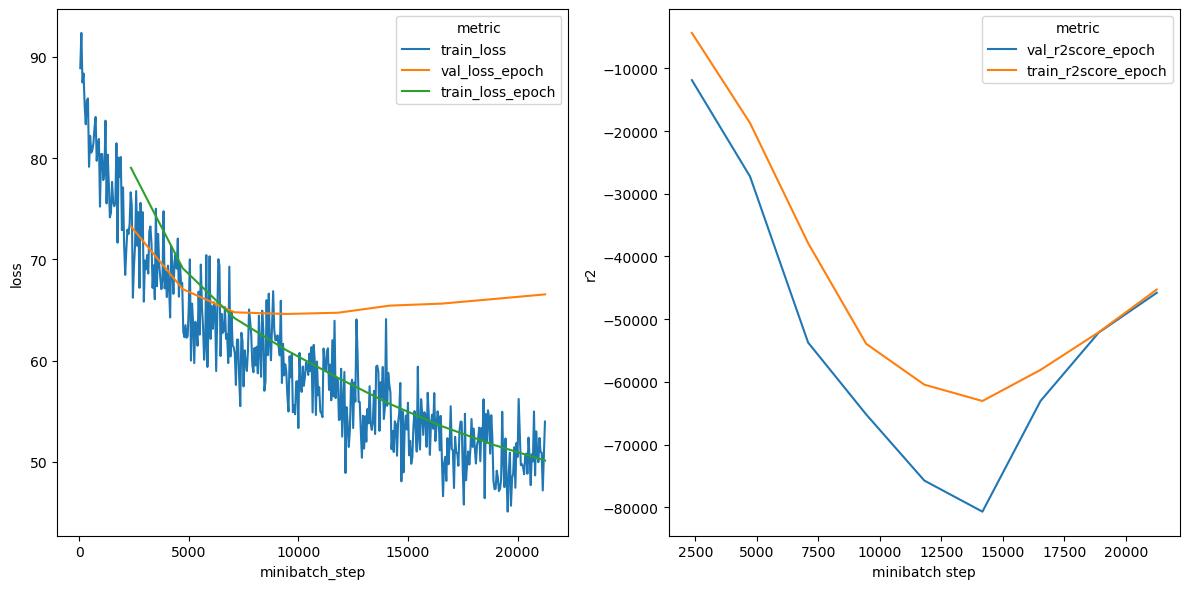

In [163]:
pl.training_summary("/cellar/users/aklie/data/datasets/AI-ATAC/analysis/10Nov23/seqdata/fold_0/AI-ATAC")

In [74]:
import torch

In [75]:
# Hyper parameters
num_classes = 81
batch_size = 100
learning_rate = 0.001
num_filters = 300

In [76]:
class ArchWrapper(nn.Module):
    def __init__(self, arch):
        super().__init__()
        self.arch = arch
    def forward(self, x):
        return self.arch(x)[0]

In [77]:
from eugene import models

In [78]:
# Define the model
model = ArchWrapper(aitac.ConvNet(num_classes, num_filters))

# Define a SequenceModule
module = models.SequenceModule(
    arch=model,
    input_len=250,
    output_dim=num_classes,
    task='regression',
    loss_fxn=aitac.pearson_loss,
    optimizer='adam',
    optimizer_lr=learning_rate,
    seed=1234
    
)
module

[rank: 0] Global seed set to 1234


SequenceModule(
  (arch): ArchWrapper(
    (arch): ConvNet(
      (layer1_conv): Sequential(
        (0): Conv2d(1, 300, kernel_size=(4, 19), stride=(1, 1))
        (1): ReLU()
      )
      (layer1_process): Sequential(
        (0): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=(0, 1), dilation=1, ceil_mode=False)
        (1): BatchNorm2d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (layer2): Sequential(
        (0): Conv2d(300, 200, kernel_size=(1, 11), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=(0, 1), dilation=1, ceil_mode=False)
        (3): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (layer3): Sequential(
        (0): Conv2d(200, 200, kernel_size=(1, 7), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=(0, 1), dilation=1, ceil_mode=False)
        (3): BatchNorm2d(200, eps=1e-05

In [164]:
model_path = "/cellar/users/aklie/data/datasets/AI-ATAC/analysis/10Nov23/seqdata/fold_0/AI-ATAC/checkpoints/epoch=3-step=9448.ckpt"

In [165]:
model_state = torch.load(model_path, map_location=torch.device("cpu"))

In [166]:
module.load_state_dict(model_state["state_dict"])

<All keys matched successfully>

In [167]:
module

SequenceModule(
  (arch): ArchWrapper(
    (arch): ConvNet(
      (layer1_conv): Sequential(
        (0): Conv2d(1, 300, kernel_size=(4, 19), stride=(1, 1))
        (1): ReLU()
      )
      (layer1_process): Sequential(
        (0): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=(0, 1), dilation=1, ceil_mode=False)
        (1): BatchNorm2d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (layer2): Sequential(
        (0): Conv2d(300, 200, kernel_size=(1, 11), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=(0, 1), dilation=1, ceil_mode=False)
        (3): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (layer3): Sequential(
        (0): Conv2d(200, 200, kernel_size=(1, 7), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=(0, 1), dilation=1, ceil_mode=False)
        (3): BatchNorm2d(200, eps=1e-05

# Load some test data

In [168]:
import seqdata as sd

In [169]:
sdata = sd.open_zarr("/cellar/users/aklie/data/datasets/AI-ATAC/analysis/10Nov23/seqdata/fold_0/ai-atac_test.zarr")

In [170]:
# reshape the ohe 
sdata['ohe_seq'] = sdata['ohe_seq'].transpose('_sequence', '_ohe', 'length')

# Eval performance

In [171]:
module.eval()

SequenceModule(
  (arch): ArchWrapper(
    (arch): ConvNet(
      (layer1_conv): Sequential(
        (0): Conv2d(1, 300, kernel_size=(4, 19), stride=(1, 1))
        (1): ReLU()
      )
      (layer1_process): Sequential(
        (0): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=(0, 1), dilation=1, ceil_mode=False)
        (1): BatchNorm2d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (layer2): Sequential(
        (0): Conv2d(300, 200, kernel_size=(1, 11), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=(0, 1), dilation=1, ceil_mode=False)
        (3): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (layer3): Sequential(
        (0): Conv2d(200, 200, kernel_size=(1, 7), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=(0, 1), dilation=1, ceil_mode=False)
        (3): BatchNorm2d(200, eps=1e-05

In [172]:
preds = module.predict(sdata["ohe_seq"].values, batch_size=2048)

Predicting on batches:   0%|          | 0/30 [00:00<?, ?it/s]

In [173]:
from eugene.evaluate.metrics._regression import calculate_pearsonr

In [174]:
targets = sdata["peak_height"].values

In [175]:
val = calculate_pearsonr(preds.T, targets.T)

In [176]:
val

array([ 0.36909894,  0.20448148, -0.05035491, ..., -0.0458083 ,
        0.05026395, -0.08890804])

In [177]:
import matplotlib.pyplot as plt

In [179]:
#find the max val
max_ind = np.argmax(val)

In [191]:
def minmax_scale(pred, true):
    subtracted = pred - min(pred)
    max_pred = max(subtracted)
    max_true = max(true)

    scaled = max_true * subtracted / max_pred
    return scaled

In [193]:
scaled = minmax_scale(preds[max_ind], targets[max_ind])

<BarContainer object of 81 artists>

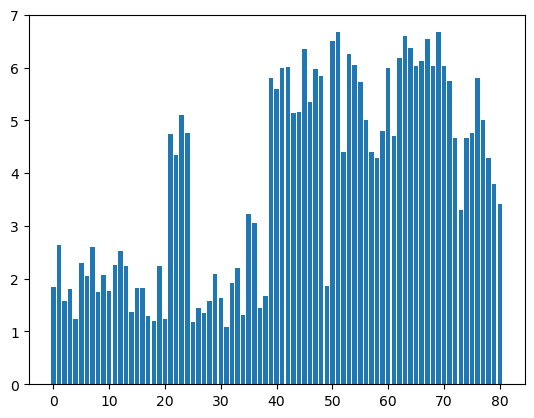

In [194]:
# Plot a barplot for the targets
import seaborn as sns
import matplotlib.pyplot as plt
plt.bar(range(len(targets[max_ind])), targets[max_ind])

<BarContainer object of 81 artists>

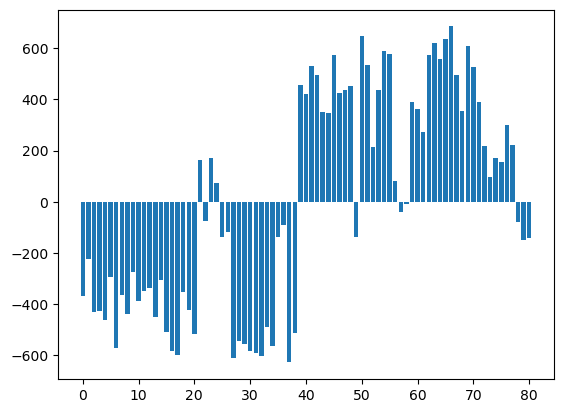

In [196]:
plt.bar(range(len(preds[max_ind])), preds[max_ind])

<BarContainer object of 81 artists>

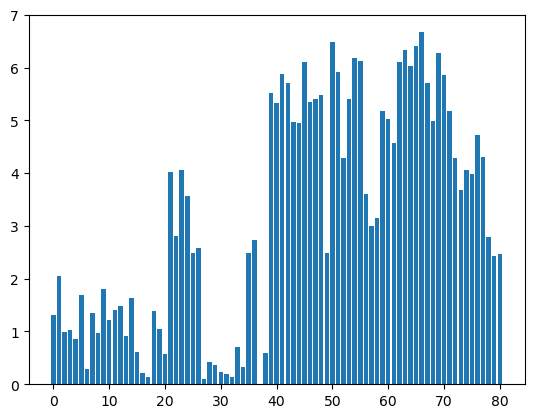

In [195]:
plt.bar(range(len(scaled)), scaled)

(array([2.000e+00, 1.000e+01, 3.600e+01, 6.500e+01, 1.160e+02, 2.360e+02,
        3.870e+02, 6.820e+02, 1.085e+03, 1.724e+03, 2.625e+03, 3.504e+03,
        4.341e+03, 4.982e+03, 5.443e+03, 5.526e+03, 5.399e+03, 5.295e+03,
        5.100e+03, 4.548e+03, 3.988e+03, 3.328e+03, 2.543e+03, 1.549e+03,
        3.740e+02]),
 array([-0.73328991, -0.66573382, -0.59817774, -0.53062166, -0.46306558,
        -0.3955095 , -0.32795342, -0.26039734, -0.19284126, -0.12528517,
        -0.05772909,  0.00982699,  0.07738307,  0.14493915,  0.21249523,
         0.28005131,  0.34760739,  0.41516347,  0.48271956,  0.55027564,
         0.61783172,  0.6853878 ,  0.75294388,  0.82049996,  0.88805604,
         0.95561212]),
 <BarContainer object of 25 artists>)

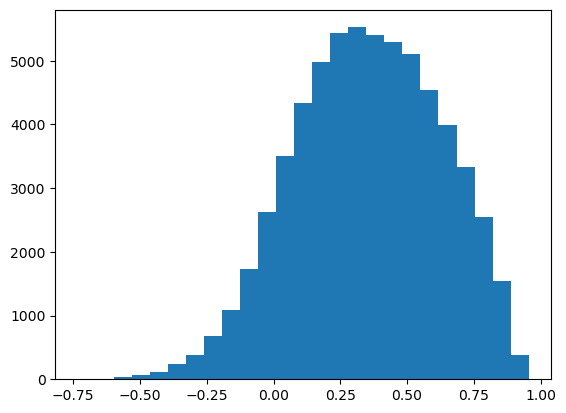

In [182]:
plt.hist(val, bins=25)

In [183]:
import torch.nn.functional as F

In [188]:
F.mse_loss(torch.tensor(preds), torch.tensor(targets))/len(targets)

/tmp/ipykernel_2801897/761524410.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.mse_loss(torch.tensor(preds), torch.tensor(targets))/len(targets)


tensor(1.3049, dtype=torch.float64)

In [189]:
nn.MSELoss()(torch.tensor(preds), torch.tensor(targets))/len(targets)

/tmp/ipykernel_2801897/604338687.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nn.MSELoss()(torch.tensor(preds), torch.tensor(targets))/len(targets)


tensor(1.3049, dtype=torch.float64)

In [190]:
aitac.pearson_loss(preds, torch.tensor(targets))/len(targets)

tensor(0.6481, dtype=torch.float64)

In [187]:
x = preds[:100]
y = torch.tensor(targets[:100])

In [119]:
mx = torch.mean(x, dim=1, keepdim=True)

In [120]:
my = torch.mean(y, dim=1, keepdim=True)

In [116]:
aitac.pearson_loss(torch.tensor(targets[:100]), preds[:100])

tensor(84.3380, dtype=torch.float64)

In [125]:
xm, ym = x - mx, y - my

In [128]:
cos = nn.CosineSimilarity(dim=1, eps=1e-6)

In [130]:
loss = torch.sum(1-cos(xm,ym))

In [132]:
cos(xm, ym)

tensor([-4.1549e-02,  1.1283e-01, -4.1818e-02,  6.9645e-02,  1.3571e-01,
         2.1687e-01,  5.0543e-01,  6.2944e-02, -3.1029e-02,  1.2728e-01,
         5.7079e-01,  3.7251e-01,  4.7936e-01,  4.3811e-01,  2.6103e-01,
        -1.0108e-01,  1.8112e-01,  1.8176e-01, -5.1281e-02,  2.8189e-02,
         7.5046e-02,  1.2638e-01,  2.8935e-01,  2.5559e-01, -3.2010e-02,
         4.9245e-01,  1.0602e-01,  3.0095e-01, -1.0266e-01, -5.6486e-03,
         2.7298e-01,  3.0367e-01,  4.0063e-01,  2.4324e-01,  1.5519e-01,
         8.1303e-02,  2.1267e-02, -2.1961e-01, -8.4991e-02, -2.8939e-02,
         3.8131e-04, -2.4874e-01,  1.6225e-01, -2.1838e-01, -3.5599e-02,
        -3.4208e-02,  2.2137e-01,  2.7339e-01,  2.3429e-01,  9.3144e-02,
        -3.6231e-02,  1.4133e-01,  5.3351e-01,  1.7066e-01,  1.1946e-01,
         2.5550e-01, -1.3263e-01,  3.6220e-01,  4.7827e-01,  2.9220e-01,
        -8.8019e-02, -1.2321e-02, -1.6875e-01,  1.1238e-01, -5.7651e-02,
         8.8672e-02, -2.9490e-02,  1.3739e-01,  2.7

In [131]:
loss

tensor(84.3380, dtype=torch.float64)

In [93]:
targets = sdata["peak_height"].values

In [102]:
sdata["ids"].values

array(['ImmGenATAC1219.peak_3', 'ImmGenATAC1219.peak_4',
       'ImmGenATAC1219.peak_6', ..., 'ImmGenATAC1219.peak_420558',
       'ImmGenATAC1219.peak_420559', 'ImmGenATAC1219.peak_420560'],
      dtype=object)

In [104]:
"ImmGenATAC1219.peak_459141" in sdata["ids"].values

False